# **Pneumonia Detection using chest Xray Images**

In this project, we will use Convolutional Neural Networks or CNNs to predict if the Xray image of the chest is penumonic or normal, the dataset used in the project is availible on kaggle. We will use different techniques such as Deep Learning, Computer Vision, Data preprocessing, Data augmentation to make the model more efficient.

In [1]:
# importing the essential libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import PIL.Image as Image
from sklearn.metrics import classification_report
import numpy as np
import cv2
import os
import pathlib


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# get the data into the notebook 
train_data = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
test_data = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

In [3]:
# here using pathlib to conveniently access the data 
train_data = pathlib.Path(train_data)
test_data = pathlib.Path(test_data)
train_data


PosixPath('/kaggle/input/chest-xray-pneumonia/chest_xray/train')

In [4]:
# printing the number of total images and number of images in each class
print("Total Number of Images: ",len(list(train_data.glob("*/*.jpeg"))))
print("Number of NORMAL Images: ",len(list(train_data.glob("NORMAL/*"))))
print("Number of PNEUMONIC Images: ",len(list(train_data.glob("PNEUMONIA/*"))))


Total Number of Images:  5216
Number of NORMAL Images:  1341
Number of PNEUMONIC Images:  3875


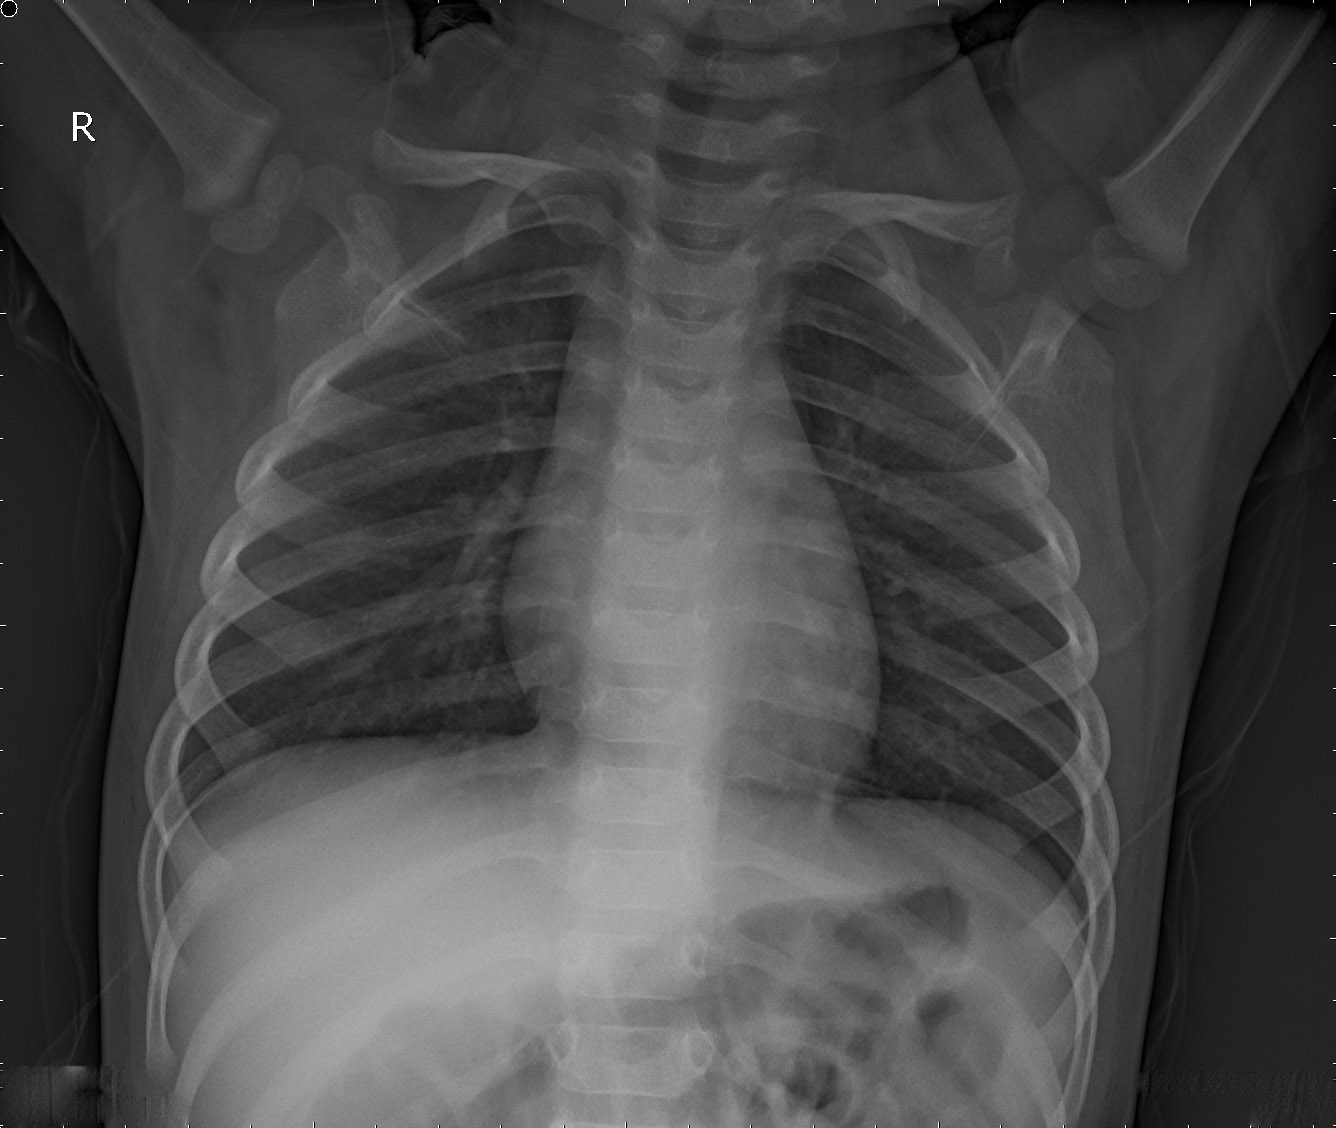

In [5]:
# this is how a normal image looks like
Image.open(str(list(train_data.glob('NORMAL/*'))[0]))

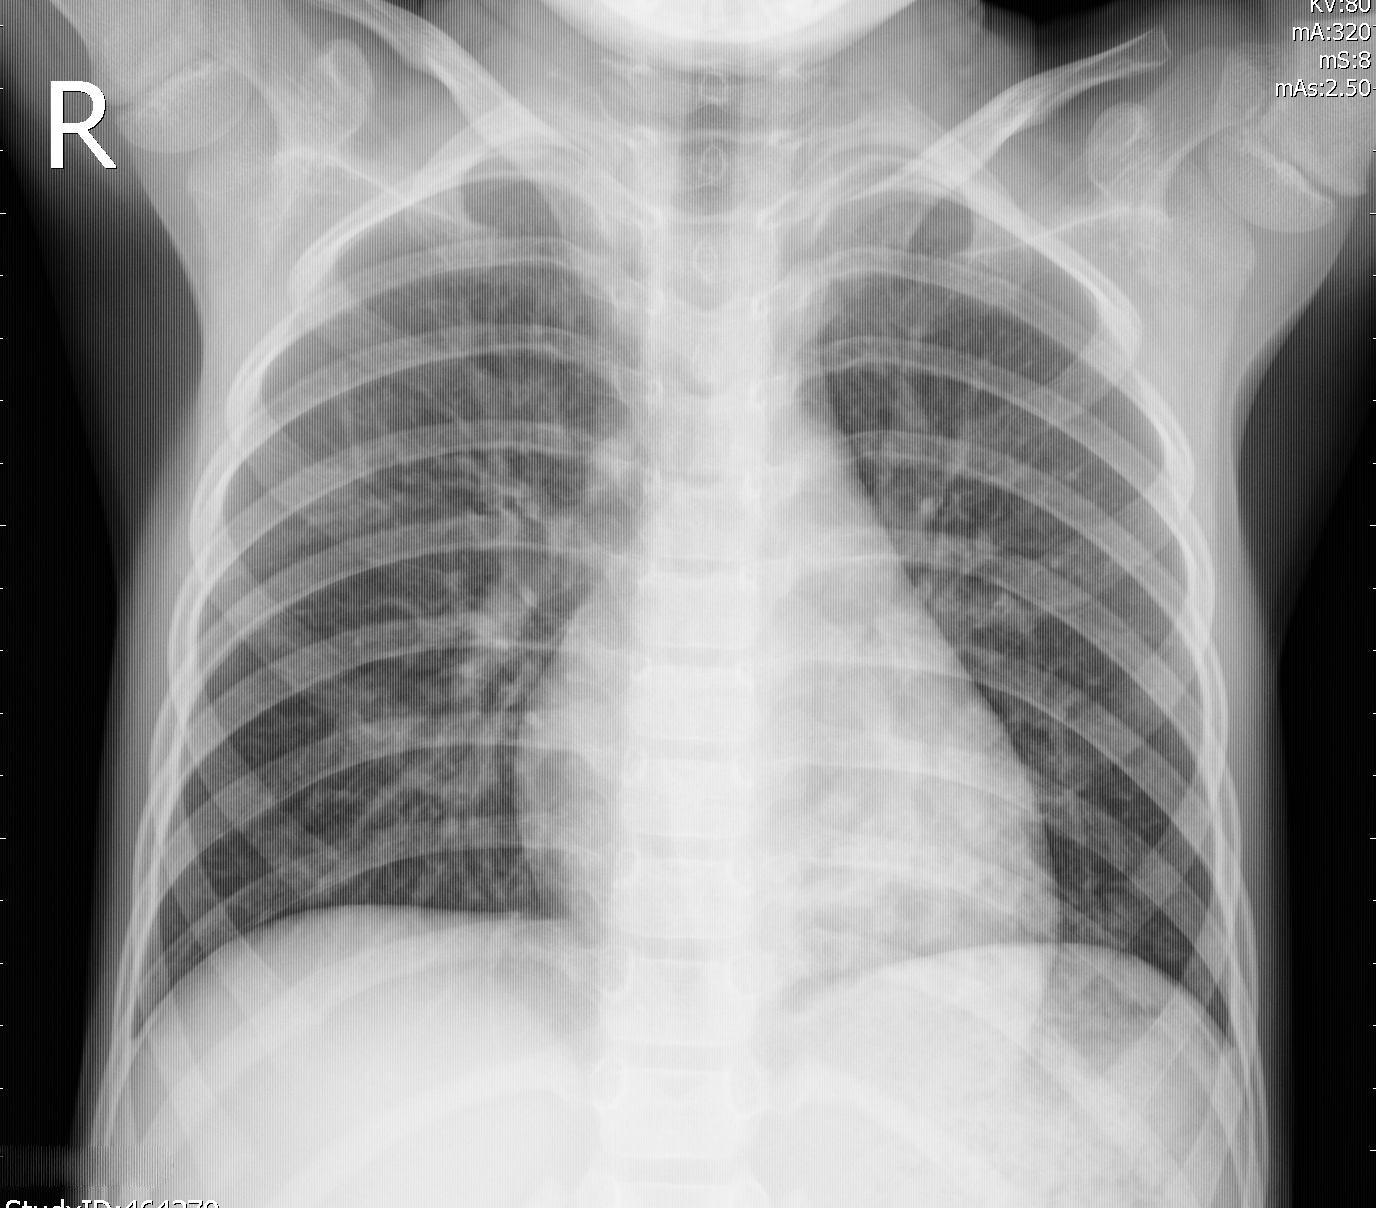

In [6]:
Image.open(str(list(train_data.glob('PNEUMONIA/*'))[2]))

Converting the image data into numpy arrays to make it ready for model training

In [7]:
print('Shape of each Image: ', cv2.imread(str(list(train_data.glob('NORMAL/*'))[0])).shape)

Shape of each Image:  (1128, 1336, 3)


In [8]:
def img_to_array(data_dir):
    # containing the different classes in two seperate dictionaries to access it later
    xray_image_dict = {
        "NORMAL" : list(data_dir.glob("NORMAL/*")),
        "PNEUMONIA" : list(data_dir.glob("PNEUMONIA/*"))
    }
    xray_image_labels = {
        "NORMAL" : 0,
        "PNEUMONIA" : 1
    }
    X,y = [],[]
    # the for loop iterates through each item in the dictionary
    for i, images in xray_image_dict.items():
        for image in images:
            img = cv2.imread(str(image)) # reads the image as numpy array
            resized_img = cv2.resize(img,(180,180)) # resizes the numpy array according to our preferences
            X.append(resized_img) # places the resized array into a list
            y.append(xray_image_labels[i]) # places the labels of the arrays into a list
    return np.array(X),np.array(y) # returns both arrays as numpy arrays 
            
        
    

In [9]:
X_data,y_data = img_to_array(train_data)
X_test,y_test = img_to_array(test_data)

In [10]:
X_test[0].shape

(180, 180, 3)

Text(0.5, 1.0, 'Count of both classes in training data')

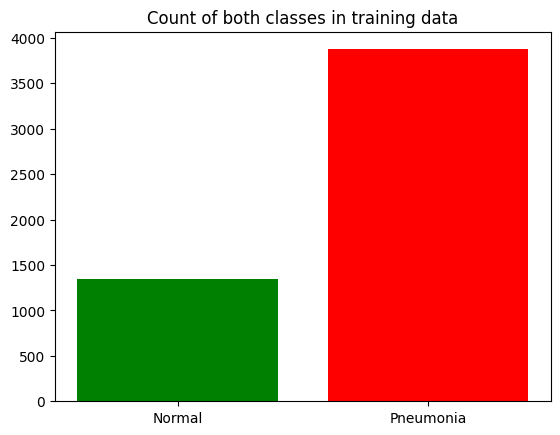

In [11]:
# visualize the number of cases in both classes
x1 = len([x for x in y_data if x ==0])
x2 = len([i for i in y_data if i ==1])

plt.bar(["Normal","Pneumonia"],[x1,x2],color=['green','red'])
plt.title('Count of both classes in training data')


Perform Data Augmentation to reduce the risk of overfitting

In [12]:
# we will synthetically generate new data in order to avoid overfitting
# we will randomly zoom,flip and contrast images for data augmentation
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal',
                                                      input_shape=(180,180,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
    keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

build the cnn model

In [13]:
model = keras.Sequential([
    # data augmentation layer
    data_augmentation,
    
    #cnn layers
    keras.layers.Conv2D(32,(3,3), strides = 1, padding = 'same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2),strides=2,padding='same'),
    
    keras.layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2),strides = 2, padding='same'),
    
    keras.layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2),strides = 2, padding='same'),
    
    keras.layers.Conv2D(128, (3,3), strides=1, padding='same', activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2),strides = 2, padding='same'),
    
    keras.layers.Conv2D(256, (3,3), strides=1, padding='same', activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2),strides = 2, padding='same'),
    
    # fully connected dense layer
    
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 90, 90, 64)       

In [18]:
# compile the model
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# scale the data before using it for training
X_train_scaled = X_data/255.0
X_test_scaled = X_test/255.0

# train the model
model.fit(X_train_scaled,y_data,epochs=5)

Epoch 1/5


2023-11-24 17:38:34.988608: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


163/163 [==============================] - 16s 73ms/step - loss: 0.1122 - accuracy: 0.9595
Epoch 2/5
163/163 [==============================] - 12s 73ms/step - loss: 0.1079 - accuracy: 0.9597
Epoch 3/5
163/163 [==============================] - 12s 74ms/step - loss: 0.0941 - accuracy: 0.9649
Epoch 4/5
163/163 [==============================] - 12s 74ms/step - loss: 0.0930 - accuracy: 0.9672
Epoch 5/5
163/163 [==============================] - 12s 74ms/step - loss: 0.0867 - accuracy: 0.9684


In [19]:
print("Test Loss of model: ", model.evaluate(X_test_scaled,y_test)[0])
print("Accuracy of the model: ",model.evaluate(X_test_scaled,y_test)[1]*100,"%")

20/20 [==============================] - 1s 17ms/step - loss: 0.4684 - accuracy: 0.8670
Test Loss of model:  0.46839025616645813
20/20 [==============================] - 0s 15ms/step - loss: 0.4684 - accuracy: 0.8670
Accuracy of the model:  86.69871687889099 %


In [20]:
preds = model.predict(X_test_scaled)
y_preds = []
for i in preds:
    if i > 0.5:
        y_preds.append(1)
    else:
        y_preds.append(0)
    
y_preds[:3]

20/20 [==============================] - 0s 15ms/step


[1, 1, 0]

print classification report

In [17]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.97      0.26      0.41       234
           1       0.69      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.83      0.63      0.61       624
weighted avg       0.79      0.72      0.66       624



At last the accuracy that we have achieved by this model is close to 87% and test loss is 0.46.